In [738]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

In [739]:
df = pd.read_parquet("taq_data\\INFY_taq.parquet")

In [740]:
df.head(100000000000000)

,timestamp,best_bid,depth_bid,best_bid_ud,depth_bid_ud,best_ask,depth_ask,best_ask_ud,depth_ask_ud,ltp,quantity
0,79631223196256,0.0,0.0,1468.0,9.0,0.0,0.0,1246.0,10.0,1331.90,5
1,79631223196257,0.0,0.0,1468.0,4.0,0.0,0.0,1246.0,5.0,1331.90,4
2,79631223196258,0.0,0.0,1465.0,1.0,0.0,0.0,1246.0,1.0,1331.90,1
3,79631223196259,0.0,0.0,1399.0,200.0,0.0,0.0,1246.7,20.0,1331.90,20
4,79631223196260,0.0,0.0,1399.0,180.0,0.0,0.0,1267.0,20.0,1331.90,20
...,...,...,...,...,...,...,...,...,...,...,...
140805,79632829617774,1355.0,2029.0,1355.5,9.0,1358.0,1.0,1357.0,767.0,1353.75,7
140806,79632834340331,1355.0,2029.0,1355.5,9.0,1358.0,1.0,1357.0,767.0,1353.75,8
140807,79632834748698,1355.0,2029.0,1355.5,9.0,1358.0,1.0,1357.0,767.0,1353.75,8
140808,79632835336864,1355.0,2029.0,1355.5,9.0,1358.0,1.0,1357.0,767.0,1353.75,1


In [741]:
df = df[df['best_bid'] <= df['best_ask']]

In [742]:
len(df)

128591

In [743]:
df = df[(df['ltp'] >= df['best_bid']) & (df['ltp'] <= df['best_ask'])]

In [744]:
len(df)

125620

In [745]:
df = df[(df['timestamp'] >= 79631223195796 + 15 * 60 * 65535) & (df['timestamp'] <= 79632829925130 - 30 * 60 * 65535)]

In [746]:
df.head(1000000000)

,timestamp,best_bid,depth_bid,best_bid_ud,depth_bid_ud,best_ask,depth_ask,best_ask_ud,depth_ask_ud,ltp,quantity
7309,79631282211319,1339.05,1.0,1339.05,7.0,1339.05,28.0,1339.05,359.0,1339.05,3
7310,79631282211320,1339.05,1.0,1339.05,4.0,1339.05,56.0,1339.05,356.0,1339.05,4
7311,79631282227852,1338.95,3.0,1338.95,14.0,1339.05,55.0,1339.05,379.0,1339.05,21
7312,79631282227853,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,358.0,1339.05,31
7313,79631282227854,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,327.0,1339.05,3
...,...,...,...,...,...,...,...,...,...,...,...
138728,79632711931781,1355.00,3024.0,1355.00,20094.0,1355.05,859.0,1355.05,4830.0,1355.00,74
138729,79632711934692,1355.00,2950.0,1355.00,20020.0,1355.05,859.0,1355.00,30.0,1355.00,30
138730,79632711935254,1355.00,2920.0,1355.00,19990.0,1355.00,16.0,1355.00,160.0,1355.00,160
138731,79632711938079,1355.00,2760.0,1355.00,19830.0,1355.05,859.0,1355.00,1.0,1355.00,1


In [747]:

import pandas as pd
import numpy as np
import time

def classify_stoll_side(df_to_classify):
    """
    - Closer to Ask -> 'Buy'
    - Closer to Bid -> 'Sell'
    - Exactly at Midpoint -> 'Mid'
    """
    n = len(df_to_classify)

    classifications = np.full(n, "Unknown", dtype=object)

    df_sorted = df_to_classify.sort_values(by='timestamp').reset_index(drop=True)

    ltp_vals = pd.to_numeric(df_sorted['ltp'], errors='coerce').values
    best_bid_vals = pd.to_numeric(df_sorted['best_bid'], errors='coerce').values
    best_ask_vals = pd.to_numeric(df_sorted['best_ask'], errors='coerce').values

    midpoint_vis_vals = (best_ask_vals + best_bid_vals) / 2
    invalid_midpoint_mask = ( np.isnan(best_ask_vals) | np.isnan(best_bid_vals) | (best_ask_vals <= best_bid_vals) )
    midpoint_vis_vals[invalid_midpoint_mask] = np.nan

    for i in range(n):
        ltp = ltp_vals[i]
        midpoint = midpoint_vis_vals[i]

        if pd.notna(midpoint) and pd.notna(ltp):
            if ltp > midpoint:
                classifications[i] = "Buy"
            elif ltp < midpoint:
                classifications[i] = "Sell"
            else:
                classifications[i] = "Mid"

    return pd.Series(classifications, index=df_to_classify.index)

print("\n--- Applying Stoll-based Trade Classification ---")
start_ts_classify = time.time()

required_cols_stoll = ['timestamp', 'ltp', 'best_bid', 'best_ask']
if all(col in df.columns for col in required_cols_stoll):
    df['classification'] = classify_stoll_side(df) 
    end_ts_classify = time.time()
    print("Trade classification complete.")
    print(df['classification'].value_counts(dropna=False))
    print(f"Classification completed in {end_ts_classify - start_ts_classify:.2f} seconds.")

    initial_rows = len(df)
    df = df[df['classification'] != "Unknown"].copy()
    print(f"Rows after removing {initial_rows - len(df)} unclassified trades: {len(df)}")

    print("\nDataFrame head with Stoll-based classification:")
    if not df.empty:
        display(df[['timestamp', 'ltp', 'best_bid', 'best_ask', 'classification']].head())
else:
    print(f"Error: Missing one or more required columns for Stoll classification: {required_cols_stoll}")



--- Applying Stoll-based Trade Classification ---
Trade classification complete.
classification
Sell       53079
Buy        35740
Unknown    28022
Mid          812
Name: count, dtype: int64
Classification completed in 0.09 seconds.
Rows after removing 28022 unclassified trades: 89631

DataFrame head with Stoll-based classification:


,timestamp,ltp,best_bid,best_ask,classification
7311,79631282227852,1339.05,1338.95,1339.05,Buy
7312,79631282227853,1339.05,1338.95,1339.05,Buy
7313,79631282227854,1339.05,1338.95,1339.05,Buy
7314,79631282227855,1339.05,1338.95,1339.05,Buy
7315,79631282227856,1339.05,1338.95,1339.05,Buy


In [748]:
df.head(10000000000000)

,timestamp,best_bid,depth_bid,best_bid_ud,depth_bid_ud,best_ask,depth_ask,best_ask_ud,depth_ask_ud,ltp,quantity,classification
7311,79631282227852,1338.95,3.0,1338.95,14.0,1339.05,55.0,1339.05,379.0,1339.05,21,Buy
7312,79631282227853,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,358.0,1339.05,31,Buy
7313,79631282227854,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,327.0,1339.05,3,Buy
7314,79631282227855,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,324.0,1339.05,25,Buy
7315,79631282227856,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,299.0,1339.05,20,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...
138727,79632711899775,1355.00,3030.0,1355.00,20100.0,1355.05,859.0,1355.00,12.0,1355.00,12,Sell
138728,79632711931781,1355.00,3024.0,1355.00,20094.0,1355.05,859.0,1355.05,4830.0,1355.00,74,Sell
138729,79632711934692,1355.00,2950.0,1355.00,20020.0,1355.05,859.0,1355.00,30.0,1355.00,30,Sell
138731,79632711938079,1355.00,2760.0,1355.00,19830.0,1355.05,859.0,1355.00,1.0,1355.00,1,Sell


In [749]:
print("Tick-level feature engineering...")

df['log_return'] = np.log(df['ltp']).diff()

df['spread'] = (df['best_ask'] - df['best_bid']) / 2
df['midpoint_vis'] = (df['best_ask'] + df['best_bid']) / 2
df['effective_spread'] = np.abs(df['ltp'] - df['midpoint_vis'])

df['buy_notional'] = np.where(df['classification'] == 'Buy', 
                                       df['ltp'] * df['quantity'], 0)
df['sell_notional'] = np.where(df['classification'] == 'Sell', 
                                        df['ltp'] * df['quantity'], 0)
df['buy_volume'] = np.where(df['classification'] == 'Buy', 
                                     df['quantity'], 0)
df['sell_volume'] = np.where(df['classification'] == 'Sell', 
                                      df['quantity'], 0)

df['mid_notional'] = np.where(df['classification'] == 'Mid', df['ltp'] * df['quantity'], 0.0) # Ensure float
df['mid_volume'] = np.where(df['classification'] == 'Mid', df['quantity'], 0.0) # Ensure float

df['H_t'] = (((df['best_bid_ud'] - df['best_bid'])/ df['best_bid']) +((df['best_ask'] - df['best_ask_ud']) / df['best_ask_ud'])) / 2
df['minute_bin'] = (df['timestamp'] // (65535 * 60))

print("Tick-level features created. Ready for aggregation.")

df.head()

Tick-level feature engineering...
Tick-level features created. Ready for aggregation.


,timestamp,best_bid,depth_bid,best_bid_ud,depth_bid_ud,best_ask,depth_ask,best_ask_ud,depth_ask_ud,ltp,...,midpoint_vis,effective_spread,buy_notional,sell_notional,buy_volume,sell_volume,mid_notional,mid_volume,H_t,minute_bin
7311,79631282227852,1338.95,3.0,1338.95,14.0,1339.05,55.0,1339.05,379.0,1339.05,...,1339.0,0.05,28120.05,0.0,21,0,0.0,0.0,0.0,20251591
7312,79631282227853,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,358.0,1339.05,...,1339.0,0.05,41510.55,0.0,31,0,0.0,0.0,0.0,20251591
7313,79631282227854,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,327.0,1339.05,...,1339.0,0.05,4017.15,0.0,3,0,0.0,0.0,0.0,20251591
7314,79631282227855,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,324.0,1339.05,...,1339.0,0.05,33476.25,0.0,25,0,0.0,0.0,0.0,20251591
7315,79631282227856,1338.95,3.0,1338.95,14.0,1339.05,59.0,1339.05,299.0,1339.05,...,1339.0,0.05,26781.00,0.0,20,0,0.0,0.0,0.0,20251591


In [750]:
print("Aggregating data to 1-minute bars...")

# Define the aggregation dictionary
agg_rules = {
    'log_return': lambda x: (x**2).sum(), 
    'spread': 'mean',
    'effective_spread': 'mean',          
    'buy_notional': 'sum',
    'sell_notional': 'sum',
    'buy_volume': 'sum',
    'sell_volume': 'sum',
    'H_t': 'mean',
    'mid_notional': 'sum',
    'mid_volume': 'sum'
}

df_agg = df.groupby('minute_bin').agg(agg_rules)

df_agg = df_agg.rename(columns={'log_return': 'RV_t', 
                                'effective_spread': 'ES_t', 
                                'spread' : 'HS_t'})

epsilon = 0
avg_buy_price = (df_agg['buy_notional'] + 0.5 * df_agg['mid_notional'])/ (df_agg['buy_volume'] + 0.5 * df_agg['mid_volume'])
avg_sell_price = (df_agg['sell_notional'] + 0.5 * df_agg['mid_notional']) / (df_agg['sell_volume'] + 0.5 * df_agg['mid_volume'])

df_agg['TS_t'] = (avg_buy_price - avg_sell_price) / 2
df_agg['TS_t'] = df_agg['TS_t'].replace(0, np.nan) # 0 means no buy or no sell
df_agg['Info_t'] = df_agg['ES_t'] - df_agg['TS_t']

final_vars = ['RV_t', 'HS_t', 'ES_t', 'TS_t', 'Info_t', 'H_t']
df_final = df_agg[final_vars].dropna()

print(f"Created {len(df_final)} 1-minute observations.")
display(df_final.head())

Aggregating data to 1-minute bars...
Created 364 1-minute observations.


,RV_t,HS_t,ES_t,TS_t,Info_t,H_t
minute_bin,,,,,,
20251591,0.000004,0.138043,0.127038,0.131960,-0.004922,0.000106
20251592,0.000002,0.109620,0.105821,-0.004809,0.110630,0.000168
20251593,0.000003,0.095407,0.089875,-0.040895,0.130770,0.000242
20251594,0.000006,0.197378,0.182925,0.075659,0.107266,0.000387
20251595,0.000002,0.119902,0.110265,0.077357,0.032909,0.000236


In [756]:
print("Identifying volatility regimes...")

rv_mean = df_final['RV_t'].mean()
rv_std = df_final['RV_t'].std()

high_vol_threshold = rv_mean + (0.3 * rv_std)
low_vol_threshold = rv_mean - ( 0.3 * rv_std)

conditions = [
    df_final['RV_t'] > high_vol_threshold,
    df_final['RV_t'] < low_vol_threshold,
]
choices = ['High-Vol', 'Low-Vol',]

df_final['Regime'] = np.select(conditions, choices, default='Normal')

print("Regime classification complete.")
print(df_final['Regime'].value_counts())

Identifying volatility regimes...
Regime classification complete.
Regime
Low-Vol     191
Normal      111
High-Vol     62
Name: count, dtype: int64


In [757]:
print("Performing comparative analysis...")

variables_to_test = ['HS_t', 'ES_t', 'TS_t', 'Info_t', 'H_t']

high_vol_group = df_final[df_final['Regime'] == 'High-Vol']
low_vol_group = df_final[df_final['Regime'] == 'Low-Vol']


results = []

for var in variables_to_test:
    high_data = high_vol_group[var].dropna()
    low_data = low_vol_group[var].dropna()
    
    mean_high = high_data.mean()
    mean_low = low_data.mean()
    difference = mean_high - mean_low
    
    t_stat, p_value = stats.ttest_ind(high_data, low_data, 
                                      equal_var=False, nan_policy='omit')
   

    results.append({
        'Variable': var,
        'Mean (Low-Vol)': mean_low,
        'Mean (High-Vol)': mean_high,
        'Difference (High - Low)': difference,
        'p-value': p_value
    })

results_df = pd.DataFrame(results).set_index('Variable')

print("\n--- RESULTS ---")
display(results_df)


Performing comparative analysis...

--- RESULTS ---


,Mean (Low-Vol),Mean (High-Vol),Difference (High - Low),p-value
Variable,,,,
HS_t,0.060934,0.144609,0.083676,6.034137e-23
ES_t,0.056957,0.129909,0.072952,3.135135e-22
TS_t,0.039866,0.067856,0.027990,1.438315e-01
Info_t,0.017091,0.062053,0.044962,2.029968e-02
H_t,0.000435,0.000447,0.000012,9.129933e-01


Generating 6 individual plots with a 25-minute rolling average...


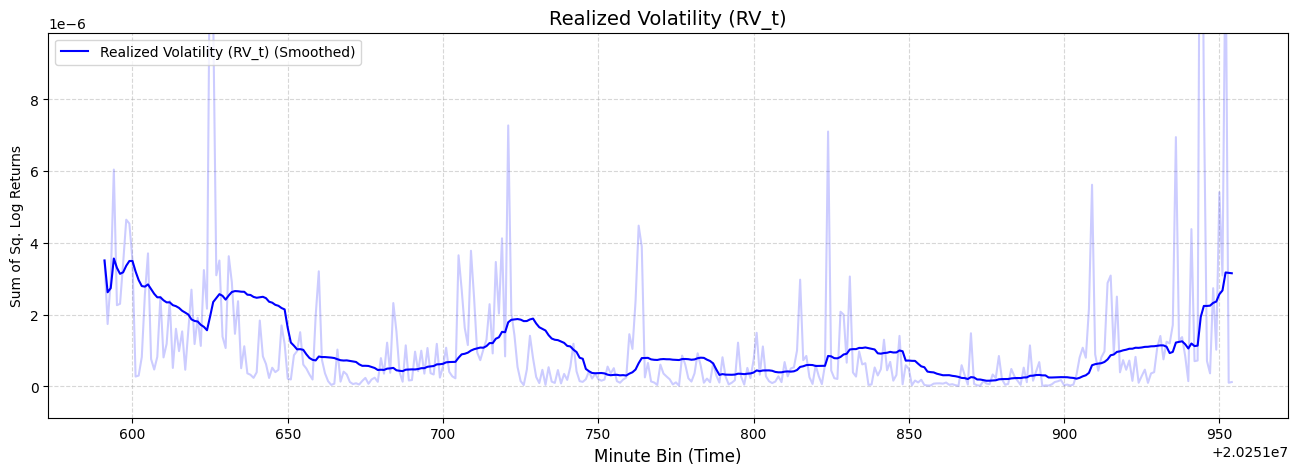

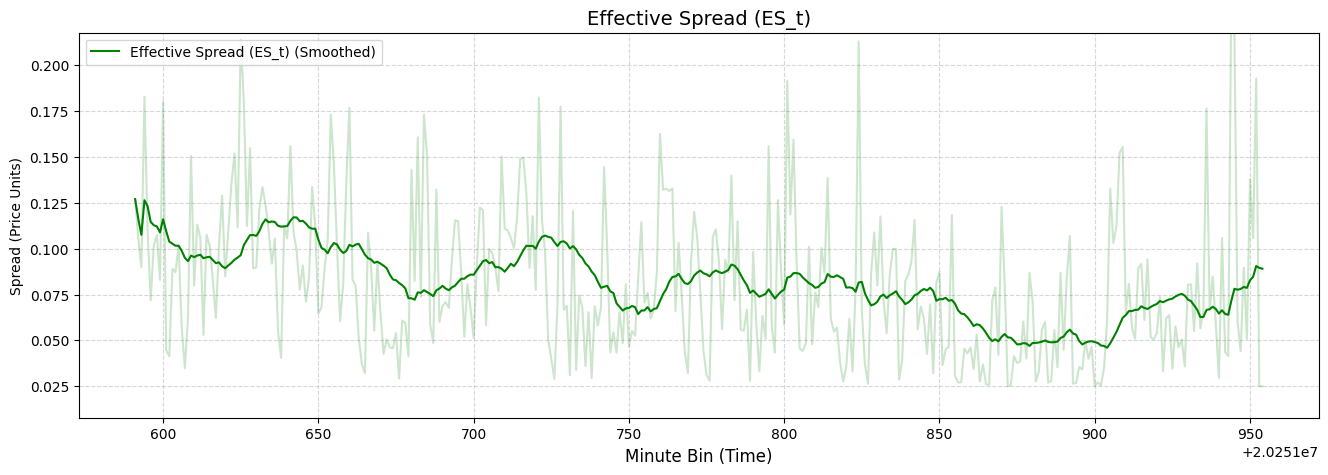

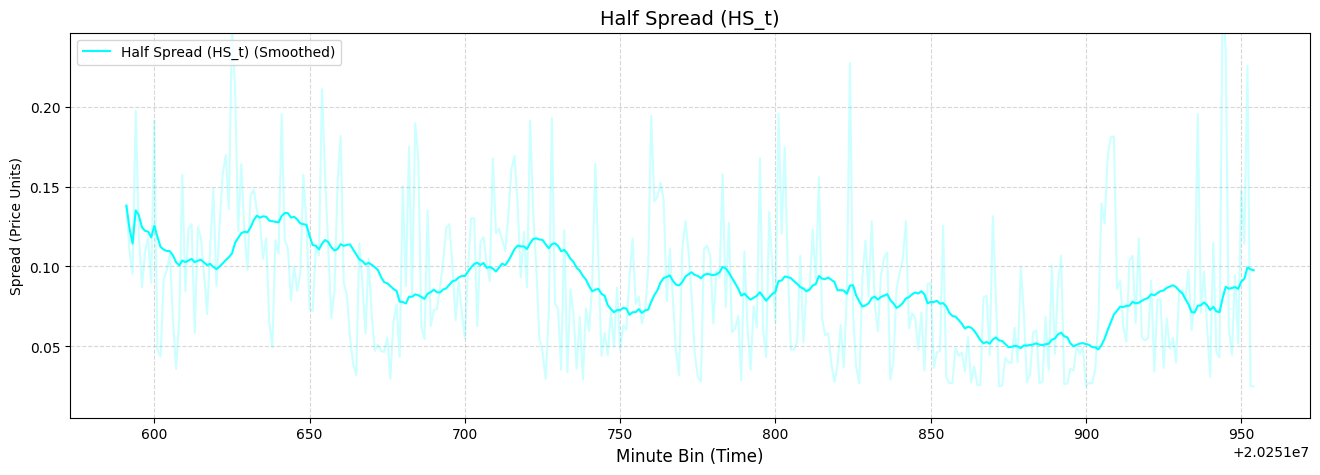

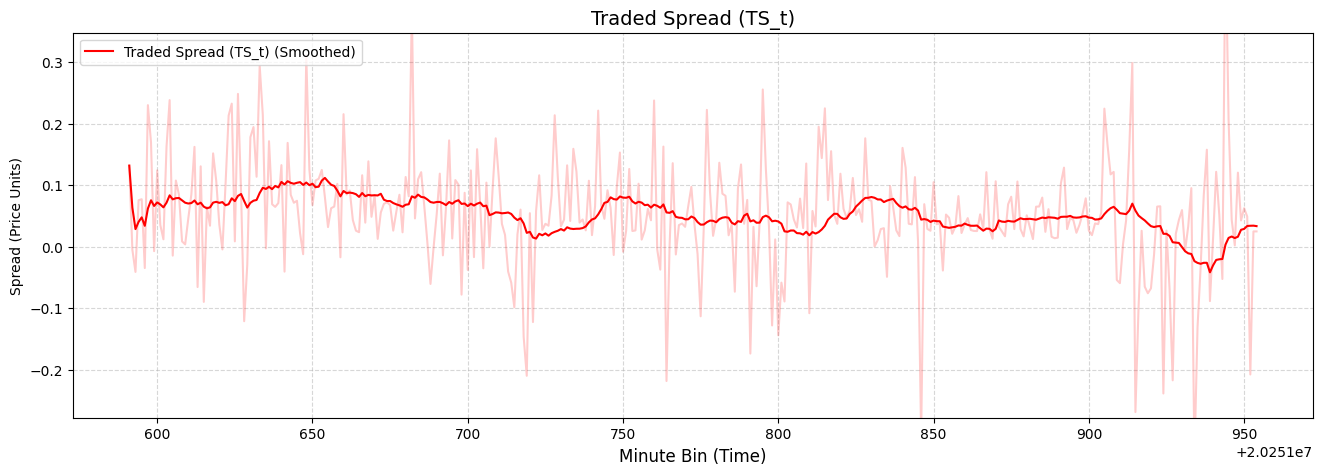

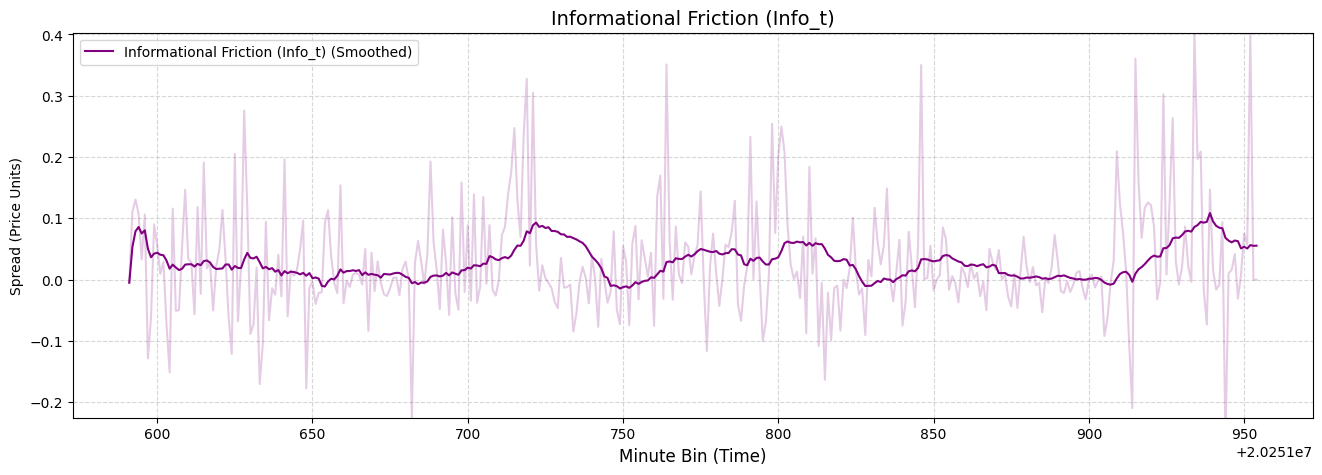

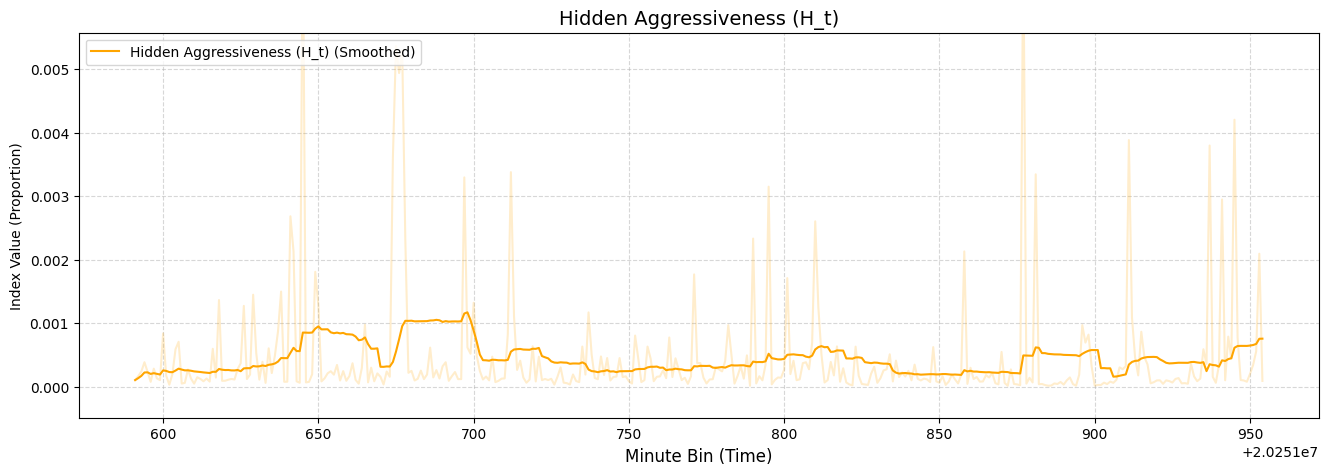

In [753]:
import matplotlib.pyplot as plt
smoothing_window = 25 

if df_final.empty:
    print("DataFrame 'df_final' is empty. No data to plot.")
else:
    H_t_calculated = 'H_t' in df_final.columns
    HS_t_calculated = 'HS_t' in df_final.columns

    plot_list = [
        {'name': 'RV_t', 'color': 'blue', 'label': 'Realized Volatility (RV_t)', 'ylabel': 'Sum of Sq. Log Returns'},
        {'name': 'ES_t', 'color': 'green', 'label': 'Effective Spread (ES_t)', 'ylabel': 'Spread (Price Units)'}
    ]
    if HS_t_calculated:
        plot_list.append({'name': 'HS_t', 'color': 'cyan', 'label': 'Half Spread (HS_t)', 'ylabel': 'Spread (Price Units)'})
    
    plot_list.extend([
        {'name': 'TS_t', 'color': 'red', 'label': 'Traded Spread (TS_t)', 'ylabel': 'Spread (Price Units)'},
        {'name': 'Info_t', 'color': 'purple', 'label': 'Informational Friction (Info_t)', 'ylabel': 'Spread (Price Units)'}
    ])
    
    if H_t_calculated:
        plot_list.append({'name': 'H_t', 'color': 'orange', 'label': 'Hidden Aggressiveness (H_t)', 'ylabel': 'Index Value (Proportion)'})

    num_plots = len(plot_list)

    print(f"Generating {num_plots} individual plots with a {smoothing_window}-minute rolling average...")

    for plot_info in plot_list:
        var_name = plot_info['name']
        
    
        if var_name not in df_final.columns:
            print(f"Skipping plot for {var_name}, column not found.")
            continue

        smooth_col_name = f"{var_name}_smooth"
        df_final[smooth_col_name] = df_final[var_name].rolling(window=smoothing_window, min_periods=1).mean()
        
        plt.figure(figsize=(16, 5)) 

        plt.plot(df_final.index, df_final[var_name], color=plot_info['color'], alpha=0.2)
        
        plt.plot(df_final.index, df_final[smooth_col_name], color=plot_info['color'], alpha=1.0, label=f"{plot_info['label']} (Smoothed)")
        
        plt.title(plot_info['label'], fontsize=14)
        plt.ylabel(plot_info['ylabel'])
        plt.xlabel('Minute Bin (Time)', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.5)
        

        if not df_final[var_name].dropna().empty:
            q_low = df_final[var_name].quantile(0.01)
            q_high = df_final[var_name].quantile(0.99)
            

            padding = (q_high - q_low) * 0.1
            if padding == 0 or pd.isna(padding):
                padding = 1.0 
            
            plt.ylim(q_low - padding, q_high + padding)
        
        plt.show()